# Sections:

* [Part One: Logistic Regression](#logreg)

    * [Aside on the Backwards Method](#backwards)

* [Part Two: Softmax Regression](#softmax)

* [Part Three: Neural Networks](#nn)

    * [Recap of Required Steps in Pytorch](#recap)

<a id='logreg'></a>

---
# 1. Logistic Regression

<img src = "./images/logisticregression_penguins.png" width = 600>


* Used for classification problems

* Can answer which class an object belongs to


## Probability Background

An object is either part of a class, or its not. Let's call $\pi_i$ the probability of being in class $y_i = 1$, and $1-\pi_i$ the probability of being in class $y_i = 0$. 

Then, this object simply follows a **Bernoulli Distribution:**

$$ P(Y_i = y_i | x_i,\pi_i) = \pi^{y_i} (1-\pi_i)^{1-y_i} $$

In our test set, we probably have more than one example. However, the examples are likely to be independent. Thus, for multiple (N) independent observations, this is promoted to:

$$ P(\vec{Y} = \vec{y}|X,\vec{\pi}) = \prod \limits_{i=1}^{N} \pi_i^{y_i} (1-\pi_i)^{n_i-y_i}$$

Let's look at the easier to use **log-likelihood:**

$$ l = log\left(P(\vec{Y} = \vec{y}|X,\vec{\pi})\right) = \sum \limits_{i=1}^{N}  y_i log(\pi_i) + (1-y_i) log(1-\pi_i) $$

This is what we want to maximize (or often times, minimize the negative log-likelihood).

So how do we estimate our probabilities?

* Use a variation on linear regression: **generalized linear models**

* For a generalized linear model you need:

    * A PDF - What type of random behaviour does our output follow? (that's our Bernoulli Distribution)
    
    * A linear model - $\eta_i = x_i^T \beta$ (this is always linear in $\beta$ - we can transform $x$ as much as we want.
    
    * A link function: how do we map our linear model onto the probabilities? Specifically, how do we relate $\eta$ to the expectation for y, $\mathbb{E}(y_i)$
    
<img src = "./images/logistic_vs_linear.jpg" >

For example, keeping $\eta$ as a linear line won't do a good job of representing probabilities, as it can go negative, or above 1. So we need a map from $\mathbb{R} -> [0,1]$

One common option is the **logistic function / sigmoid function:**

$$ \pi_i \equiv \sigma(\eta_i) = \frac{1}{1+e^{-\eta_i}} $$

Whose inverse is the **logit:**

$$ \eta = logit(\pi) = log\left(\frac{\pi}{1-\pi}\right) $$

So our linear function, $\eta$, is actually telling us about the **log-odds** of our response. (Changes in our features cause $e^\beta$ changes to the odds).

## Derivatives, Hessians, and more oh my.

Now that we know how to relate our output values, $y_i$, to our features, $X$, we want to actually find a solution. 

We find a solution by 'simply' maximizing the log-likelihood*:

$ \frac{\partial l}{\partial \beta_j} = 0, \forall j \in 1...p$

This is typically not doable by hand. We can apply gradient descent:

$$ \beta^{k+1} = \beta^k - \alpha \nabla_\beta (l)$$

Or perhaps Newton-Rhapson:

$$ \beta^{k+1} = \beta^k - \gamma H^{-1} \nabla_\beta (l)$$

To do an iterative approach to solving for these.

(For the curious, the derivative and Hessian are:)

$$ \frac{\partial l}{\partial \beta_j} = \sum \limits_{i=1}^{N} y_i x_{ij} -  \pi_i x_{ij} $$

$$ H_{jk} = - \sum \limits_{i=1}^{N}  \pi_i(1-\pi_i) x_{ik} x_{ij} $$




Luckily, in pytorch we can skip all this and run straight to the solution. 

\* Although the theory behind what is happening comes from probability theory, the ML community seems to typically be more comfortable with loss functions. In pytorch, and most other packages, you will see this more commonly termed the **Cross-Entropy Loss Function**, which we try to minimize: 

$$ Cross Entropy Loss = -\frac{1}{N} \sum \limits_{i=1}^{N}  y_i log(\sigma(\eta_i)) + (1-y_i) log(1-\sigma(\eta_i)) $$

As written, this is technically the **Binary Cross Entropy Loss**, but it can be extended to multiple classes. More on multiclassifications later...

# 1. Logistic Regression in PyTorch

### Initialize all the Things

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import logistic_regression_extra as lre # This is extra, not a standard python package, just for plots and stuff.

In [2]:
# Create some dummy data (from the extra lre file)
data_set=lre.DataLogistic()

# Create a loader object (will make more sense later)
# Should comment that the batch_size variable here is the one that sets the batch size in your optimization loops
trainloader=DataLoader(dataset=data_set,batch_size=5)

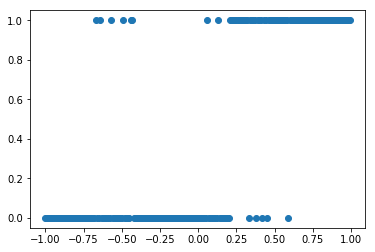

In [3]:
plt.plot(data_set.x.numpy(),data_set.y.numpy(),'o')
plt.show()

In [4]:
# Create a logistic function class
class logistic_regression(nn.Module):
    
    # n_inputs = number of input parameters. You DON'T have to add a bias here!
    def __init__(self,n_inputs):
        super(logistic_regression,self).__init__()
        
        # this creates a linear layer with 1 output
        self.linear=nn.Linear(n_inputs,1)
        
    # The most important part of any pytorch class is the forward function!    
    def forward(self,x):
        
        # Here we build up the layers. In the case of logistic regression, we apply sigmoid to our linear function
        yhat=torch.sigmoid(self.linear(x))
        return yhat

<a id='backwards'></a>
### A brief aside on forwards/backwards and the autograd function in PyTorch

In [5]:
# Set up the independent variable with the requires_grad flag
x = torch.tensor(-3.0,requires_grad=True)
print('x',x.data)
# Can't return the gradient because it hasn't been calculated yet
print('x grad',x.grad,'(not calculated yet)')

x tensor(-3.)
x grad None (not calculated yet)


In [6]:
# Create some y value that is a function of that x
y = x**2
print('y=x^2 = ',y.data)

# Calculate the gradient
# Note that you call x.grad, NOT y.grad to view the value
y.backward()
print('dy/dx at x=-3 = ',x.grad)

y=x^2 =  tensor(9.)
dy/dx at x=-3 =  tensor(-6.)


In [7]:
# If we try to make a new function of x...
y = x**3
print('y=x^3 = ',y.data)

# ...It won't overwrite the old value, but add it on
y.backward()
print('dy/dx = 3x^2 + 2x, as grad not zeroed = ',x.grad)

y=x^3 =  tensor(-27.)
dy/dx = 3x^2 + 2x, as grad not zeroed =  tensor(21.)


In [8]:
y = x**4
print('y = x^4 = ', y.data)

# So this time let's zero it out
x.grad.zero_()
print('dy/dx now zeroed = ',x.grad)

y.backward()
print('dy/dx = 4x^3 = ',x.grad)

y = x^4 =  tensor(81.)
dy/dx now zeroed =  tensor(0.)
dy/dx = 4x^3 =  tensor(-108.)


In [9]:
# If we try to call y again, we'll hit an error, as it removes graphs after they've been used
#y.backward()

In [10]:
# You can add a flag to tell y to keep its graph, and call it over and over
y = x**2
x.grad.zero_()
y.backward(retain_graph=True)
print(x.grad, 'able to do again because of the retain_graph command')

y.backward(retain_graph=True)
print(x.grad, 'and again')

tensor(-6.) able to do again because of the retain_graph command
tensor(-12.) and again


### Back to Logistic Regression...

<Figure size 432x288 with 0 Axes>

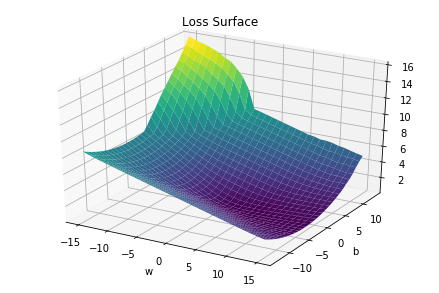

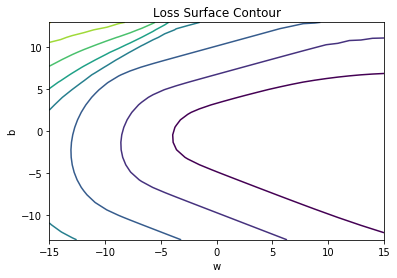

In [11]:
# Let's actually start using our model

# 1. Create a model object, with the 1 = number of parameters we are using. 
model = logistic_regression(1)
get_surface=lre.plot_error_surfaces(15,13,data_set[:][0],data_set[:][1],30)
plt.show()

# NOTE: there are actually 2 ways to make the model. You can also use the sequential object:
model1 = nn.Sequential(nn.Linear(1,1),nn.Sigmoid())    

# Don't need to do this, this just updates the initial weights to be more awful than the good guessing points it starts with
model.state_dict() ['linear.weight'].data[0]=torch.tensor([[-5]])
model.state_dict() ['linear.bias'].data[0]=torch.tensor([[-10]])

# 2. Define your cost function
# When you call this, it's called as criterion(yhat,y)
criterion=nn.BCELoss()

# 3. Define your optimizer (gradient descent,adagrad,...,PyTorch has many to choose from)
learning_rate=1
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train the model

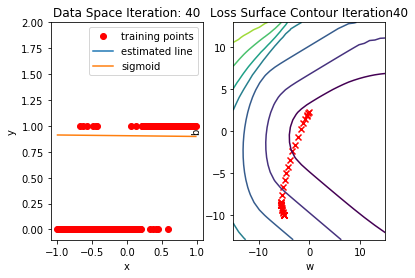

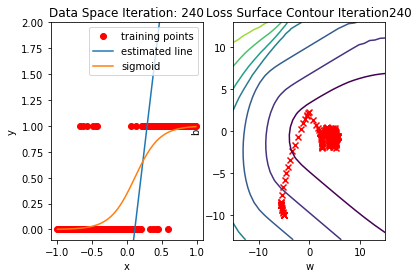

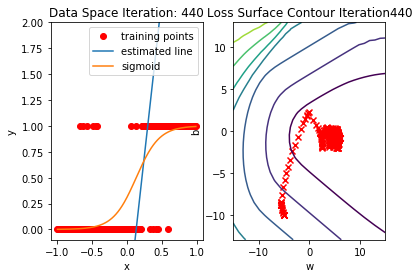

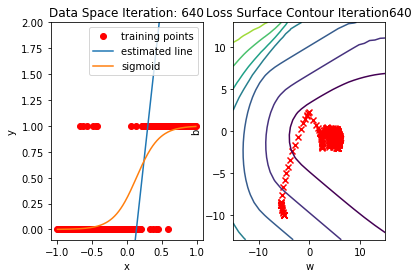

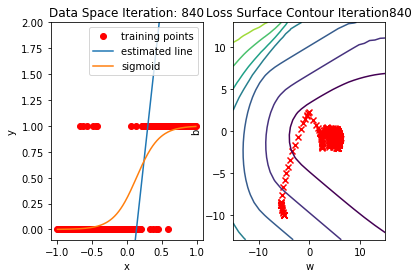

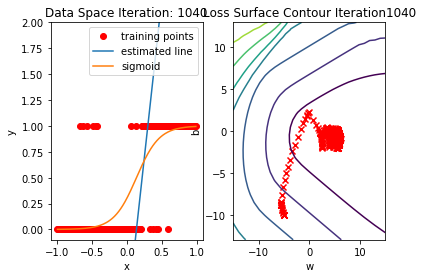

In [12]:
max_iter = 30
for epoch in range(max_iter):
    
    # The trainloader has x and y loaded in a tuple for easy access
    # It is loaded into batches, so that it optimizes based on each batch, until all batches are done,
    # and then increases max_iter
    # Stochastic GD has batch_size = 1
    # Regular GD has batch_size = N
    
    for x,y in trainloader:
        
        #make a prediction 
        yhat= model(x)
        
        #calculate the loss
        loss = criterion(yhat, y)
        
        #clear gradient
        optimizer.zero_grad()
        
        # Backward pass: compute gradient of the loss with respect to all the learnable parameters
        # It automatically calculates all of these for you
        loss.backward()
        
        # The step function on an Optimizer makes an update to its parameters
        optimizer.step()
        
        #for plotting
        get_surface.get_stuff(model,loss.tolist())
        
    if epoch%5==0:
        get_surface.plot_ps()

In [13]:
# Make Actual Predictions

# yhat is your probability of y being = 1
yhat=model(data_set.x)

# We can vary the value of 0.5 to get different thresholds to improve different types of errors
label=yhat>0.5
print(torch.mean((label==data_set.y.type(torch.ByteTensor)).type(torch.float)))

# Confusion matrix
confusion_matrix(data_set.y,label)

tensor(0.9000)


array([[106,  12],
       [  8,  74]], dtype=int64)

## Error Types

<img src = "./images/confusion.png" >


<a id='softmax'></a>

---
# 2. Softmax Regression

<img src = "./images/logistic_vs_softmax.png" >

The main difference is how an altered 'sigmoid' function is defined:

We now have multiple linear outputs, $\eta_i$ for i=1...K classes.  

Softmax function defined as:

$$ g_i = \frac{e^{\eta_i}}{\sum \limits_{i=1}^K e^{\eta_i}} $$

Whichever $g_i$ has the largest output is the predicted class.

In [14]:
# Use the MNIST data set
train_dataset=dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

validation_dataset=dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
validation_dataset

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=100)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=5000)

tensor(3)


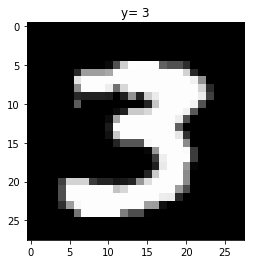

In [15]:
# Visualize the data
ndata = 27
print(train_dataset[ndata][1])
lre.show_data(train_dataset[ndata])

Note that because this data is images, we will have to unroll the matrices of X's into vectors. 

This can be done easily in PyTorch using the X.view(-1) command

In [16]:
#Build a classifier
class SoftMax(nn.Module):
    
    def __init__(self,input_size,output_size):
        super(SoftMax,self).__init__()
        self.linear=nn.Linear(input_size,output_size)
        
    def forward(self,x):
        # Note that when doing softmax, you don't add a sigmoid here
        # This is taken care of during the criterion step
        z=self.linear(x)
        return z

In [17]:
# These will be the dimensions of our classifier. 10 outputs for 10 numbers
input_dim=28*28
output_dim=10

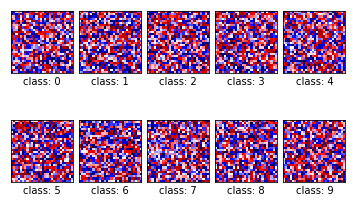

In [18]:
# Build our model
model=SoftMax(input_dim,output_dim)

# Again, we could actually use the sequential
#model = nn.Sequential(nn.Linear(input_dim,output_dim)) 

lre.PlotParameters(model)

# Loss Function
# When using CrossEntropyLoss, your y data needs to be of type long
criterion=nn.CrossEntropyLoss()

# Optimizer
learning_rate=0.1
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train the model

In [19]:
n_epochs=10
loss_list=[]
accuracy_list=[]
N_test=len(validation_dataset)

for epoch in range(n_epochs):
    for x, y in train_loader:
      

        #clear gradient 
        optimizer.zero_grad()
        
        #make a prediction 
        z=model(x.view(-1,28*28))
        
        # calculate loss 
        loss=criterion(z,y)
        
        # calculate gradients of parameters 
        loss.backward()
        
        # update parameters 
        optimizer.step()
        
        
        
    correct=0
    #perform a prediction on the validation  data  
    for x_test, y_test in validation_loader:

        z=model(x_test.view(-1,28*28))
        _,yhat=torch.max(z.data,1)

        correct+=(yhat==y_test).sum().item()
        
   
    accuracy=correct/N_test
    
    loss_list.append(loss.data)
    accuracy_list.append(accuracy)

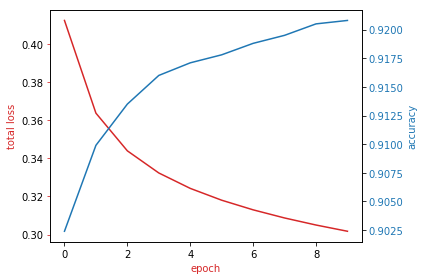

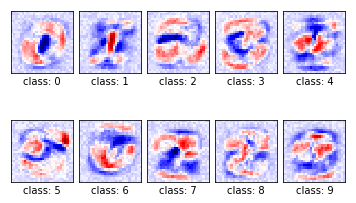

In [20]:
# Analyze Results

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

lre.PlotParameters(model)

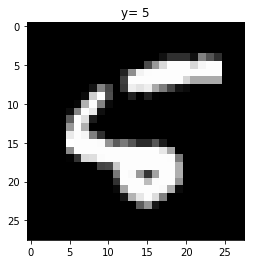

yhat: tensor([6])


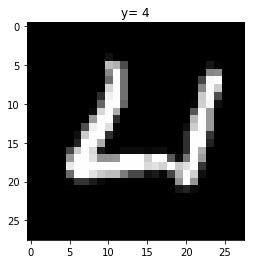

yhat: tensor([6])


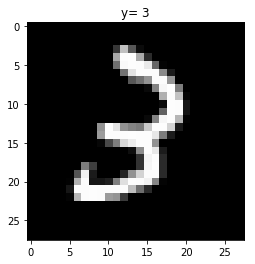

yhat: tensor([2])


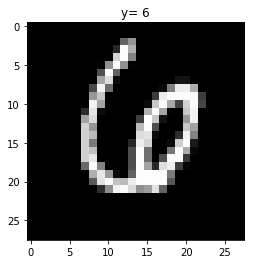

yhat: tensor([7])


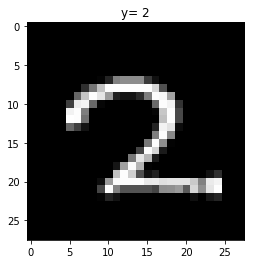

yhat: tensor([7])


In [21]:
# First 5 misclassified
count=0
for x,y in validation_dataset:

    z=model(x.reshape(-1,28*28))
    _,yhat=torch.max(z,1)
    if yhat!=y:
        lre.show_data((x,y))

        plt.show()
        print("yhat:",yhat)
        count+=1
    if count>=5:
        break 

<a id='nn'></a>

---
# 3. Neural Nets

## Premise and Forward Propagation

<img src = "./images/neuralnet.jpeg" width=600 >

<img src = "./images/nn1.png" width=600>

Neural networks work extremely well for non-linear data. The above data could not easily be separated by logistic regression. 

To make predictions, we need to move from our data, $X$, through the hidden layers, $a_i$, through to our output(s) ($y_i$). The output can correspond to a single class for binary classification, or multiple classes.

To move from one layer to the next:

Focus on a single example, i. First create a linear sum of the previous layer (don't forget to include a bias):

$$ \vec{z_i^l} = \beta^{l-1} \vec{a_i^{l-1}} $$ 

Then apply some activation function (more on this later)

$$ \vec{a_i^l} = activation(z_i^l) $$

Continue until you reach the final layer. At this point, you may apply various final activations depending on the type of model you are doing:

* Regression: No activation

* Binary Classification: Sigmoid

* Multiclass Classification: No activation (remember, gets applied during the SoftMax step)

At this point, you make predictions just as you would any other set of data. 



## Activation Functions

$$
\begin{aligned}
sigmoid = \sigma(x) &= \frac{1}{1+e^{-x}} 
\\
tanh(x) &= \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}
\\
relu(x) &= \begin{cases}
            x &x>0 \\
            0 &x<0
           \end{cases}
\end{aligned}
$$

<img src = "./images/activation.png" width=400><img src = "./images/activation_deriv.png" width=400>

Sigmoid is used less in modern neural networks. Tanh somtimes outperforms ReLU for small epochs (in terms of accuracy), but ReLU typically takes over in the end. Key point is that there is a **vanishing gradient** issue with tanh and sigmoid, which ends up being a problem during backpropagation. (Essentially, if the gradient goes to zero, it becomes very hard to vary the weights). 

## Backward Propagation

[This is a good resouce for the basics behind backprop](https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html)

![BackpropVisual](./images/backprop_visually.png)

Basic premise:

* Computationally efficient method 

    $\mathcal{O}(d)$ vs $\mathcal{O}(e^d)$
    
* Utilizes chain rule to move backwards

* Utilizes repeating derivatives to avoid repetitive calculations 

![memo](./images/memoization.png)

Can summarize the steps required:

$$
\begin{aligned}
\delta_{L} &= \frac{\partial J}{\partial a^L} \frac{\partial a^L}{\partial z^L}
\\
\delta_k &= \delta_{k+1} \beta^K \frac{\partial g}{\partial z^k}
\\
\frac{\partial J}{\partial \beta_k} &= \delta_k a^k
\end{aligned}
$$


Once again, luckily in PyTorch we don't actually care about any of this. We can just build up the neural network, and let the package take care of all the backend stuff. 

## Neural Networks in PyTorch

There are 3 main ways to build a NN in PyTorch:

* Create a NN class

* Use the sequential function

* Create a variable sized NN class

Implementation Note: Remember that BCE is for Binary, CrossEntropy is for multiclass. 

In [22]:
# A fixed size NN, but with variable layer sizes
# This net has 2 hidden layers
class NetRelu(nn.Module):
    def __init__(self,D_in,H1,H2,D_out):
        super(NetRelu,self).__init__()
        self.linear1=nn.Linear(D_in,H1)
        self.linear2=nn.Linear(H1,H2)
        self.linear3=nn.Linear(H2,D_out)
      
    def forward(self,x):
        x=torch.relu(self.linear1(x))  
        x=torch.relu(self.linear2(x))
        x=self.linear3(x)
        return x

# Second option: a class with variable sized number of layers
# Layers = [D_in,H1,H2,...,Hn,D_out]
class NNVary(nn.Module):
    
    # for a variable sized NN, we can adjust the number of layers we want.
    # Layers is a list that contains the size of each hidden layer
    def __init__(self,Layers):
        super(NNVary,self).__init__()
        
        # A ModuleList is an object that carries specifically torch modules
        self.hidden = nn.ModuleList()

        for input_size,output_size in zip(Layers,Layers[1:]):
            self.hidden.append(nn.Linear(input_size,output_size))
        
    def forward(self,activation):
        L=len(self.hidden)
        for (l,linear_transform)  in zip(range(L),self.hidden):
            if l<L-1:
                activation =torch.relu(linear_transform(activation))
           
            else:
                activation =linear_transform(activation)
        
        return activation

In [23]:
# Training Function
def train(data_set,model,criterion, train_loader, optimizer, epochs=100):
    LOSS=[]
    ACC=[]
    for epoch in range(epochs):
        for x,y in train_loader:
            optimizer.zero_grad()
        
            yhat=model(x)
            loss=criterion(yhat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        LOSS.append(loss.item())
        ACC.append(accuracy(model,data_set))
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(LOSS,color=color)
    ax1.set_xlabel('epoch',color=color)
    ax1.set_ylabel('total loss',color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot( ACC, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    return LOSS

In [24]:
# Accuracy: remember for SoftMax, the max value along each y is the class that is chosen.
def accuracy(model,data_set):
    _,yhat=torch.max(model(data_set.x),1)
    return (yhat==data_set.y).numpy().mean()

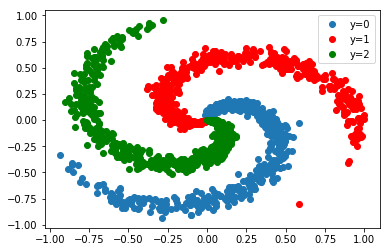

In [36]:
# Create some data
data_setNN=lre.DataNN()
data_setNN.plot_stuff()
data_setNN.y=data_setNN.y.view(-1)
train_loader=DataLoader(dataset=data_setNN,batch_size=20)

In [37]:
# Create model
# We now have three ways to choose a model:
# Let's do 2 hidden layers, each of size 50

# Standard NN class
model = NetRelu(2,30,30,3)

# Variable size NN class
#model = NNVary([2,50,50,3])

# Sequential
#model = nn.Sequential(nn.Linear(2,50),nn.ReLU(),
#                     nn.Linear(50,50),nn.ReLU(),
#                     nn.Linear(50,3)
#                     )

In [38]:
# Set the optimizer you will use and the criterion you want

#Optimizer
learning_rate=0.10
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

# Criterion
criterion=nn.CrossEntropyLoss()

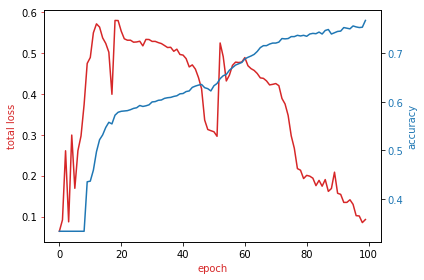

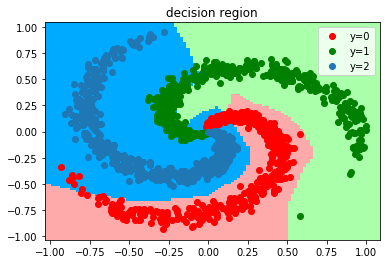

In [39]:
# That's it! Now we can train the model and view some results

LOSS=train(data_setNN,model,criterion, train_loader, optimizer, epochs=100)

lre.plot_decision_regions_3class(model,data_setNN)

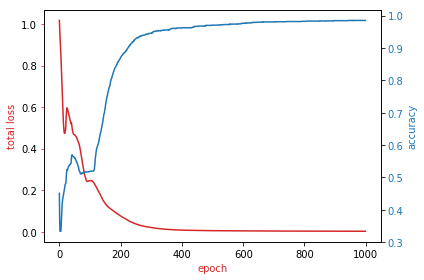

tensor([[-0.7316,  0.0793,  0.5908],
        [-0.6429,  0.0658,  0.5176],
        [-0.5888,  0.1451,  0.3998],
        ...,
        [-5.3011, -1.3711,  7.4847],
        [-8.7454,  0.0141,  9.6881],
        [-3.6982, -0.5927,  5.3209]], grad_fn=<AddmmBackward>)

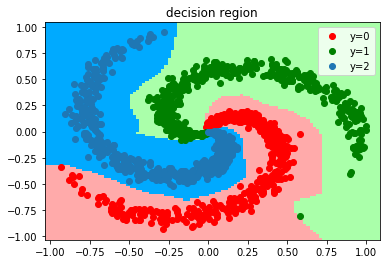

In [43]:
# Let's do it again, but with an extra layer
Layers=[2,30,30,30,3]
model=NNVary(Layers)
learning_rate=0.01

optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

criterion=nn.CrossEntropyLoss()
LOSS=train(data_setNN,model,criterion, train_loader, optimizer, epochs=1000)
lre.plot_decision_regions_3class(model,data_setNN)

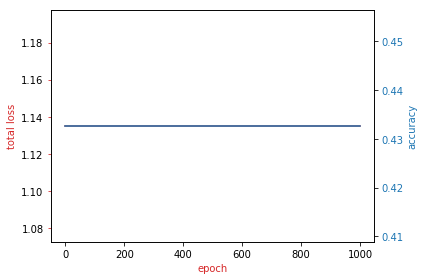

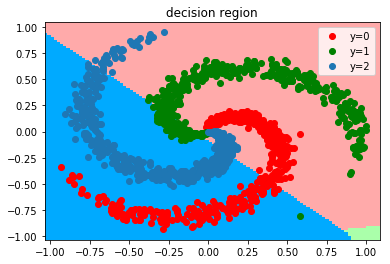

In [42]:
# Compare with SoftMax
model=SoftMax(2,3)
LOSS=train(data_setNN,model,criterion, train_loader, optimizer, epochs=1000)
lre.plot_decision_regions_3class(model,data_setNN)

<a id='recap'></a>


---
# Recap 

To summarize, let me just list out explicitly the steps that you need to follow in PyTorch to create a successful model 

(Note that the only real variation comes in the 'model' choice, but the rest is very formulaic).

**1. Import some data**
    
   * This should be from the **[Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) class**. Basically, the python \_\_getitem\_\_ [] method needs to return a tuple that contains your data (x,y). 
    
   * If done this way, it can automatically be loaded into a dataloader that will batch and shuffle the data for you. 
   
      * train_loader=DataLoader(dataset=data_set,batch_size=N)
   
   
**2. Build a Model**

   * This can be done in a variety of ways.
   
   
   * One option is to build your own nn.Module class.
       
       * model = NN(d_in,H1,H2,d_out)
       
   
   * Another option is to build a nn.Sequential object. 
   
       * model = nn.Sequential(
                   nn.Linear(D_in,H1),   nn.Activation(),
                   nn.Linear(H1,H2),     nn.Activation(),
                   ...
                   nn.Linear(H(N-1),HN), nn.Activation(),
                   nn.Linear(HN,D_out))
                        
**3. Choose an Optimizer**

   * There are [many](https://pytorch.org/docs/stable/optim.html) for possible optimizers you may choose. 
   
   * Some popular ones include:
   
       * Stochastic Gradient Descent: torch.optim.SGD(params, lr=0.1, momentum = 0.4)
       
       * Adam: torch.optim.Adam(params, lr = 0.001)
       
       * AdaGrad: torch.optim.Adagrad(params, lr=0.01, weight_decay=0)
       
**4. Choose a Criterion Function**

   * Again, there are [many](https://pytorch.org/docs/stable/nn.html#id51) options here.
   
   * Main choices:
   
       * Least Squares: nn.MSELoss()
       
       * Binary Classification: nn.BCELoss()
       
       * Multiclass: nn.CrossEntropyLoss()
       
**5. Train your Model!**

   For each epoch:
   
   1. Gather the mini-batch from your data loader: (for x, y in train_loader:)

   2. Make a prediction: yhat = **model(x)**
   
   3. Calculate loss: loss = **criterion(yhat,y)**
   
   4. Clear gradient: **optimizer.zero_grad()**
   
   5. Calculate gradients of all learnable parameters: **loss.backward()**
   
   6. Use the gradients to update your model: **optimizer.step()**
   
**6. Make Predictions and Analyze Results**

   * Typically, SoftMax will require finding the maximum along the columns of y. 
  
       * ysoftmax = model(data_set.x) -----> This is n x K sized
   
       * _,yhat=torch.max(ysoftmax,1) -----> This is n sized, with each value the corresponding class
       
   * Calculate accuracy by comparing with known results.
   
       * (yhat==data_set.y).numpy().mean()
       
And that's it! You can use this template to build far more complicated models.

(e.g. Deep Nets with more detailed looks at preventing overfitting (next week), Convolutional Nets, the last week of the course) 